In [1]:
import matplotlib
import matplotlib.pyplot as plt

from datasets import get_dataset

import numpy as np
np.random.seed(123)

import random
random.seed(123)

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adadelta, SGD
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
import cv2
import pdb
import progressbar
import os
from scipy import stats
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
n_views = 5
dataset = 'kr-vs-kp'

In [3]:
# Algorithm:
# Input: L, U, Learn
# Output: H
# 1. Partition L into (v_1, v_2, ..., v_n)
# 2. Learn h_i on v_i using Learn
# 3. while (one of h_i changes):
# 	3.1 Q = []
# 	3.2 for i in range(n):
#         if majority on classifiers other than h_i has better accuracy on L: 
#             for u in U:
#                 if more than 50% of classifiers other than h_i agree on u:
#                     Q_i = Q_i Union {u, prediction(u)}
# 	3.3 for i in range(n):
#           Learn h_i on L Union q_i
# 4. Output H = Majority Over h_i

In [4]:
# 1. Partition L into (v_1, v_2, ..., v_n)
ds = get_dataset(dataset, 0.7, 0.25)
[L_x, L_y], U, [test_x, test_y] = ds.get_data()
V = []
for ind in range(n_views):
    left = int(ind * L_x.shape[0] / n_views)
    right = int((ind+1) * L_x.shape[0] / n_views)
    V.append([L_x[left:right], L_y[left:right]])

In [5]:
# 2. Learn h_i on v_i using Learn
H = []
n_attr = V[ind][0].shape[1]

for ind in range(n_views):
    h = Sequential()
    h.add(Dense(input_shape=(n_attr,), units=n_attr / 2))
    h.add(Activation('relu'))
    h.add(BatchNormalization())
    h.add(Dense(units=n_attr/5))
    h.add(Activation('relu'))
    h.add(BatchNormalization())
    h.add(Dropout(0.5))
    h.add(Dense(units=V[ind][1].shape[1]))
    h.add(Activation('softmax'))
    h.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    H.append(h)

for ind in range(n_views):
    H[ind].fit(V[ind][0], V[ind][1], epochs=50, batch_size=32, validation_split=0.2, verbose=True)
    print H[ind].evaluate(test_x,test_y)

Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 0s - loss: 1.6728 - acc: 0.4174 - val_loss: 0.7178 - val_acc: 0.4828
Epoch 2/50
115/115 [==============================] - 0s - loss: 1.6121 - acc: 0.4609 - val_loss: 0.7142 - val_acc: 0.5172
Epoch 3/50
115/115 [==============================] - 0s - loss: 1.5632 - acc: 0.4000 - val_loss: 0.7106 - val_acc: 0.5517
Epoch 4/50
115/115 [==============================] - 0s - loss: 1.4943 - acc: 0.4435 - val_loss: 0.7088 - val_acc: 0.5172
Epoch 5/50
115/115 [==============================] - 0s - loss: 1.2814 - acc: 0.5391 - val_loss: 0.7033 - val_acc: 0.5517
Epoch 6/50
115/115 [==============================] - 0s - loss: 1.4410 - acc: 0.4696 - val_loss: 0.6958 

In [6]:
# 3
changed = True
to_plot = []
num_runs = 0
while (changed and num_runs <= 10):
    print num_runs
    preds_L = []
    for ind in range(n_views):
        preds_L.append(H[ind].predict(L_x))
    preds_L = np.array(preds_L)
    preds_L = np.argmax(preds_L, axis=2)
    
    preds_U = []
    for ind in range(n_views):
        preds_U.append(H[ind].predict(U))
    preds_U = np.array(preds_U)
    preds_U = np.argmax(preds_U, axis=2)
    
    perfs = []
    test_preds = []
    for ind in range(n_views):
        test_preds.append(np.argmax(H[ind].predict(test_x), axis=1))
    test_preds = np.array(test_preds)
    
    for ind in range(n_views):
        perf = accuracy_score(np.argmax(test_y, axis=1), test_preds[ind])
        perfs.append(perf)
    perfs.append(accuracy_score(np.argmax(test_y, axis=1),
                                np.reshape(stats.mode(test_preds, axis=0)[0], (-1,))))
    to_plot.append(perfs)
    
    Q = []
    update = [False for _ in range(n_views)]
    for cur in range(n_views):
        elems_take = [view_ind for view_ind in range(n_views) if view_ind != cur]
        preds_others_L = preds_L[elems_take]
        preds_others_U = preds_U[elems_take]
        
        acc_others_L = accuracy_score(np.argmax(L_y, axis=1), 
                                      np.reshape(stats.mode(preds_others_L, axis=0)[0], (-1,)))
        acc_cur_L = accuracy_score(np.argmax(L_y,axis=1), preds_L[cur])
        q_cur = [[], []]
        if acc_others_L > acc_cur_L:
            update[cur] = True
            for u_ind in range(preds_U.shape[1]):
                mode_prediction = stats.mode(preds_others_U[:, u_ind])[0][0]
                if np.sum(preds_others_U[:, u_ind] == mode_prediction) >= 0.5 * (n_views - 1):
                    q_cur[0].append(U[u_ind])
                    label_temp = [0, 0]; label_temp[mode_prediction] = 1
                    q_cur[1].append(label_temp)
        Q.append([np.array(q_cur[0]), np.array(q_cur[1])])
    for cur in range(n_views):
        if update[cur]:
            comb_x = np.concatenate([L_x, Q[cur][0]], axis=0)
            comb_y = np.concatenate([L_y, Q[cur][1]], axis=0)
            H[cur].fit(comb_x, comb_y, epochs=20, batch_size=32, validation_split=0.2, verbose=False)
    
    preds_L_new = []
    for ind in range(n_views):
        preds_L_new.append(H[ind].predict(L_x))
    
    preds_U_new = []
    for ind in range(n_views):
        preds_U_new.append(H[ind].predict(U))
    
    same = (preds_L == preds_L_new) and (preds_U == preds_U_new)
    changed = not same
    num_runs += 1

0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:66: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


1
2
3
4
5
6
7
8
9
10


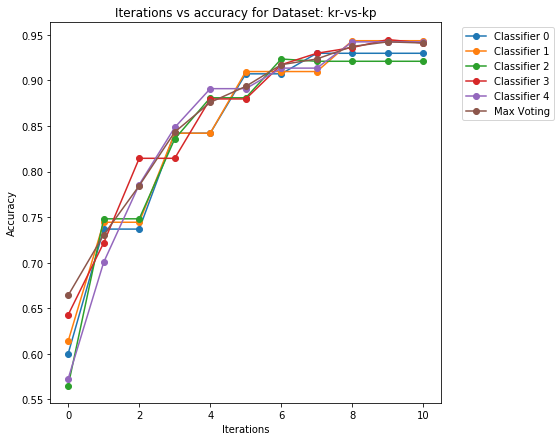

In [7]:
plt.figure(figsize=(7, 7))
plt.clf()
handles = []
labels = []
for ind in range(n_views):
    ys = [x[ind] for x in to_plot]
    handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = str(ind))
    handles.append(handle)
    labels.append('Classifier %d' % ind)
ys = [x[n_views] for x in to_plot]
handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = 'Overall')
handles.append(handle)
labels.append('Max Voting')

plt.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left")
# plt.legend(handles, labels)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Iterations vs accuracy for Dataset: %s' % dataset)
plt.show()